Import libraries

In [1033]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from xgboost import plot_importance
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

Import files

In [1034]:
characters = pd.read_csv("../Clean data/clean_character_data.csv")
movies = pd.read_csv("../Clean data/clean_movie_data.csv")
inputs = pd.read_csv("../Clean data/inputs.csv")

column_names = list(inputs.columns)
print(column_names)

['Wiki ID', 'Freebase ID_x', 'Movie name', 'Release date_x', 'Revenue', 'Runtime', 'IMDb rating', 'Wins', 'Nominations', 'Release year_x', 'Languages', 'Genres', 'Countries', 'United States of America-onehot', 'United Kingdom-onehot', 'India-onehot', 'Canada-onehot', 'Germany-onehot', 'Japan-onehot', 'South Korea-onehot', 'Argentina-onehot', 'France-onehot', 'United Kingodm-onehot', 'Spain-onehot', 'Ireland-onehot', 'Hong Kong-onehot', 'China-onehot', 'Russia-onehot', 'Australia-onehot', 'Italy-onehot', 'Mexico-onehot', 'New Zealand-onehot', 'Brazil-onehot', 'Belgium-onehot', 'Denmark-onehot', 'Sweden-onehot', 'Netherlands-onehot', 'Philippines-onehot', 'Thriller-onehot', 'Science Fiction-onehot', 'Horror-onehot', 'Adventure-onehot', 'Action-onehot', 'Drama-onehot', 'Comedy-onehot', 'Romance Film-onehot', 'Musical-onehot', 'Fantasy-onehot', 'Family Film-onehot', 'Crime Fiction-onehot', 'Indie-onehot', 'World cinema-onehot', 'Mystery-onehot', 'Black-and-white-onehot', 'Crime Thriller-on

Quick look at inputs

In [1035]:
inputs.head()

,Wiki ID,Freebase ID_x,Movie name,Release date_x,Revenue,Runtime,IMDb rating,Wins,Nominations,Release year_x,...,Actor birth year_y,F-onehot_y,M-onehot_y,White_y,Black/African American_y,South Asian_y,East Asian_y,American Indian/Alaska Native_y,Pacific Islander_y,Other_y
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,2.315268e+07,98.0,4.9,NaN,2.0,2001,...,1969.0,0.0,1.0,0,1,0,0,0,0,0
1,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,5.8,NaN,NaN,1997,...,1964.0,1.0,0.0,0,0,0,0,0,0,1
2,171005,/m/016ywb,Henry V,1989-11-08,2.398142e+07,137.0,7.5,12.0,13.0,1989,...,1959.0,1.0,0.0,1,0,0,0,0,0,0
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,9.655040e+08,139.0,7.8,22.0,17.0,1964,...,1917.0,0.0,1.0,0,0,0,0,0,0,1
4,156558,/m/014k4y,Baby Boy,2001-06-27,4.855272e+07,123.0,6.4,1.0,14.0,2001,...,1970.0,1.0,0.0,0,1,0,0,0,0,0


In [1036]:
inputs.shape

(10918, 105)

In [1037]:
# Assuming 'Revenues' is the column in your DataFrame 'df'
max_revenue = inputs['Revenue'].max()
min_revenue = inputs['Revenue'].min()

print("Maximum Revenue:", max_revenue)
print("Minimum Revenue:", min_revenue)


Maximum Revenue: 9522959437.465649
Minimum Revenue: 336.5110586513585


In [1038]:
# DataFrame with revenues higher than 1,000,000,000
high_revenue_df = inputs[inputs['Revenue'] > 1000000000]

# DataFrame with revenues lower than 1,000
low_revenue_df = inputs[inputs['Revenue'] < 1000000]

In [1039]:
high_revenue_df.shape

(99, 105)

In [1040]:
low_revenue_df.shape

(952, 105)

All inputs analysis

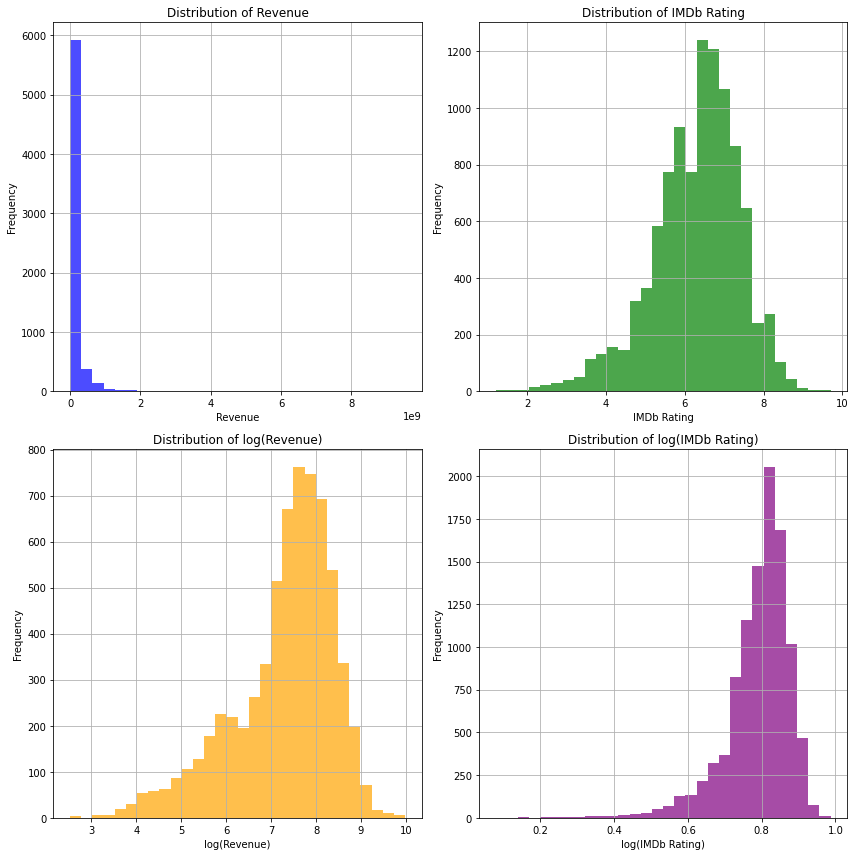

In [1041]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'Revenues' and 'IMDb_Rating' are columns in your DataFrame 'df'
revenues = inputs['Revenue']
imdb_ratings = inputs['IMDb rating']

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot for Revenue
axes[0, 0].hist(revenues, bins=30, alpha=0.7, color='blue')
axes[0, 0].set_title('Distribution of Revenue')
axes[0, 0].set_xlabel('Revenue')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True)

# Plot for IMDb Rating
axes[0, 1].hist(imdb_ratings, bins=30, alpha=0.7, color='green')
axes[0, 1].set_title('Distribution of IMDb Rating')
axes[0, 1].set_xlabel('IMDb Rating')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# Plot for log-transformed Revenue
axes[1, 0].hist(np.log10(revenues), bins=30, alpha=0.7, color='orange')
axes[1, 0].set_title('Distribution of log(Revenue)')
axes[1, 0].set_xlabel('log(Revenue)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True)

# Plot for log-transformed IMDb Rating
axes[1, 1].hist(np.log10(imdb_ratings), bins=30, alpha=0.7, color='purple')
axes[1, 1].set_title('Distribution of log(IMDb Rating)')
axes[1, 1].set_xlabel('log(IMDb Rating)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True)

plt.tight_layout()  # Adjusts the spacing between plots
plt.show()


Tail-cut inputs analysis

In [1042]:
min_revenue_threshold = 100000  # Set your minimum revenue threshold
max_revenue_threshold = 1000000000  # Set your maximum revenue threshold

filtered_revenues_inputs = inputs[(inputs['Revenue'] > min_revenue_threshold) & (inputs['Revenue'] < max_revenue_threshold)]

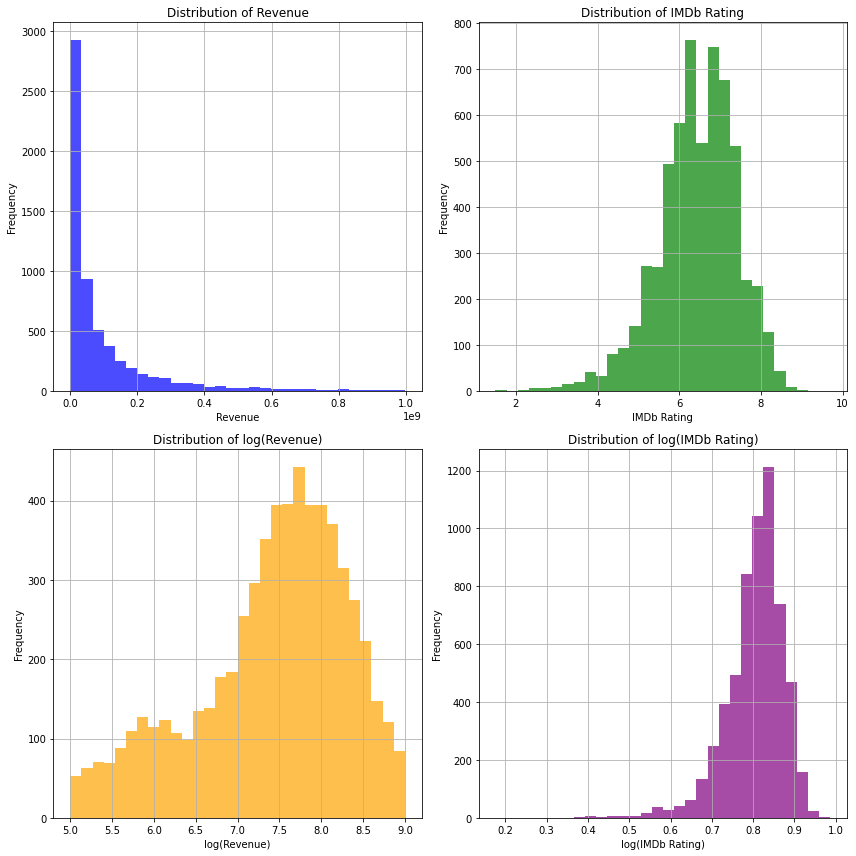

In [1043]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'Revenues' and 'IMDb_Rating' are columns in your DataFrame 'df'
revenues = filtered_revenues_inputs['Revenue']
imdb_ratings = filtered_revenues_inputs['IMDb rating']

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot for Revenue
axes[0, 0].hist(revenues, bins=30, alpha=0.7, color='blue')
axes[0, 0].set_title('Distribution of Revenue')
axes[0, 0].set_xlabel('Revenue')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True)

# Plot for IMDb Rating
axes[0, 1].hist(imdb_ratings, bins=30, alpha=0.7, color='green')
axes[0, 1].set_title('Distribution of IMDb Rating')
axes[0, 1].set_xlabel('IMDb Rating')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# Plot for log-transformed Revenue
axes[1, 0].hist(np.log10(revenues), bins=30, alpha=0.7, color='orange')
axes[1, 0].set_title('Distribution of log(Revenue)')
axes[1, 0].set_xlabel('log(Revenue)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True)

# Plot for log-transformed IMDb Rating
axes[1, 1].hist(np.log10(imdb_ratings), bins=30, alpha=0.7, color='purple')
axes[1, 1].set_title('Distribution of log(IMDb Rating)')
axes[1, 1].set_xlabel('log(IMDb Rating)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True)

plt.tight_layout()  # Adjusts the spacing between plots
plt.show()


Modelling functions

In [1044]:
def feat_and_target_revenue(data):
    feature = data.drop(['Revenue', 'IMDb rating'], axis = 1)
    target = np.log10(data['Revenue'])

    return feature, target

In [1045]:
def feat_and_target_critics(data):
    feature = data.drop(['IMDb rating', 'Revenue'], axis = 1)
    target = (data['IMDb rating'])

    return feature, target

In [1046]:
def data_splitting(feature, target):
    #Returns x_train, x_test, y_train, y_test
    return train_test_split(feature, target, test_size=0.2, random_state=42) 

In [1047]:
def fit_model_revenue(model_name, xtrain, xtest, ytrain, ytest):
    if model_name == 'RandomForest':
        model = RandomForestRegressor(
    max_depth=13,
    max_features=0.5044385141334264,
    min_samples_leaf=4,
    min_samples_split=15,
    n_estimators=140,
    random_state=42
)  # Adjust parameters as needed
    elif model_name == 'XGB':
        model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree = 0.5382140919340437, 
    gamma = 1.0628444205682614,
    max_depth = 7, 
    min_child_weight = 1, 
    n_estimators = 70, 
    reg_alpha = 40
)
    elif model_name == 'GBM':
        model = GradientBoostingRegressor(
    learning_rate=0.048040737541705625,
    max_depth=4,
    min_samples_leaf=8,
    min_samples_split=5,
    n_estimators=200,
    subsample=0.7977456176958748,
    random_state=42
)

    else:
        print("Invalid model name.")
        return
    
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    mse = mean_squared_error(ytest, ypred)
    print("RMSE:", math.sqrt(mse))
    variance = ytest.std()
    print("Std:", variance)
    errors = abs(ytest - ypred)
    mean_error = np.mean(errors)
    print("Mean Absolut Error:", mean_error)

    if model_name == 'XGBoost':
        plot_importance(model, max_num_features=30)  # This function is specific to XGBoost
    else:
        # Plotting histograms for RandomForest and GBM
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].hist(ypred, bins=30, alpha=0.7, color='blue')
        axes[0].set_title('Distribution of Predictions')
        axes[0].set_xlabel('Predictions')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True)

        axes[1].hist(ytest, bins=30, alpha=0.7, color='red')
        axes[1].set_title('Actual Values')
        axes[1].set_xlabel('Values')
        axes[1].set_ylabel('Frequency')
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

    if model_name in ['RandomForest', 'XGB', 'GBM']:
        joblib.dump(model, f'{model_name}_revenue_model.pkl')
        print(f"{model_name} model trained and saved.")



In [1048]:
def fit_model_critics(model_name, xtrain, xtest, ytrain, ytest):
    if model_name == 'RandomForest':
        model = RandomForestRegressor(
    max_depth=17,
    max_features=0.5013884710633058,
    min_samples_leaf=9,
    min_samples_split=14,
    n_estimators=110,
    random_state=42
)  # Adjust parameters as needed
    elif model_name == 'XGB':
        model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree = 0.8040762773750969, 
    gamma = 0.014551544273050691,
    max_depth = 7, 
    min_child_weight = 1.8067173676269164, 
    n_estimators = 200, 
    reg_alpha = 0.28332090854937586
) 
    elif model_name == 'GBM':
        model = GradientBoostingRegressor(
    learning_rate=0.058359413134240305,
    max_depth=4,
    min_samples_leaf=10,
    min_samples_split=2,
    n_estimators=150,
    subsample=0.6268043574324423,
    random_state=42
) 
    else:
        print("Invalid model name.")
        return
    
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    mse = mean_squared_error(ytest, ypred)
    print("RMSE:", math.sqrt(mse))
    variance = ytest.std()
    print("Std:", variance)
    errors = abs(ytest - ypred)
    mean_error = np.mean(errors)
    print("Mean Absolut Error:", mean_error)

    if model_name == 'XGBoost':
        plot_importance(model, max_num_features=30)  # This function is specific to XGBoost
    else:
        # Plotting histograms for RandomForest and GBM
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].hist(ypred, bins=30, alpha=0.7, color='blue')
        axes[0].set_title('Distribution of Predictions')
        axes[0].set_xlabel('Predictions')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True)

        axes[1].hist(ytest, bins=30, alpha=0.7, color='red')
        axes[1].set_title('Actual Values')
        axes[1].set_xlabel('Values')
        axes[1].set_ylabel('Frequency')
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

    if model_name in ['RandomForest', 'XGB', 'GBM']:
        joblib.dump(model, f'{model_name}_critics_model.pkl')
        print(f"{model_name} model trained and saved.")

In [1049]:
def pipeline_revenue(data, model_name):
    feature, target = feat_and_target_revenue(data)
    xtrain, xtest, ytrain, ytest = data_splitting(feature, target)
    fit_model_revenue(model_name, xtrain, xtest, ytrain, ytest)
def pipeline_critics(data, model_name):
    feature, target = feat_and_target_critics(data)
    xtrain, xtest, ytrain, ytest = data_splitting(feature, target)
    fit_model_critics(model_name, xtrain, xtest, ytrain, ytest)

#'XGB': Refers to the XGBoostRegressor model.
#'RandomForest': Refers to the RandomForestRegressor model from scikit-learn.
#'GBM': Refers to the GradientBoostingRegressor model from scikit-learn.

Inputs formation

In [1050]:
to_keep = ['Revenue', 'IMDb rating','M-onehot_x', 'M-onehot_y', 'Runtime', 'Release year_x', 'United States of America-onehot', 'United Kingdom-onehot', 'India-onehot', 'Canada-onehot', 'Germany-onehot', 'Japan-onehot', 'South Korea-onehot', 'Argentina-onehot', 'France-onehot', 'United Kingodm-onehot', 'Spain-onehot', 'Ireland-onehot', 'Hong Kong-onehot', 'China-onehot', 'Russia-onehot', 'Australia-onehot', 'Italy-onehot', 'Mexico-onehot', 'New Zealand-onehot', 'Brazil-onehot', 'Belgium-onehot', 'Denmark-onehot', 'Sweden-onehot', 'Netherlands-onehot', 'Philippines-onehot', 'Thriller-onehot', 'Science Fiction-onehot', 'Horror-onehot', 'Adventure-onehot', 'Action-onehot', 'Drama-onehot', 'Comedy-onehot', 'Romance Film-onehot', 'Musical-onehot', 'Fantasy-onehot', 'Family Film-onehot', 'Crime Fiction-onehot', 'Indie-onehot', 'World cinema-onehot', 'Mystery-onehot', 'Black-and-white-onehot', 'Crime Thriller-onehot', 'Actor height_x', 'Actor age at release_x', 'F-onehot_x', 'White_x', 'Black/African American_x', 'South Asian_x', 'East Asian_x', 'American Indian/Alaska Native_x', 'Pacific Islander_x', 'Other_x', 'Actor height_y', 'Actor age at release_y', 'F-onehot_y', 'White_y', 'Black/African American_y', 'South Asian_y', 'East Asian_y', 'American Indian/Alaska Native_y', 'Pacific Islander_y', 'Other_y']
#'Wins', 'Nominations','M-onehot_x', 'M-onehot_y'

all_inputs = inputs[to_keep]
inputs_filt = filtered_revenues_inputs[to_keep]

print("Number of features is: " + str(len(to_keep)))
all_inputs = all_inputs.dropna()

# List of columns to drop
columns_to_drop = ['Actor height_x', 'Actor height_y']
# Dropping the specified columns
inputs_filt = inputs_filt.dropna()
play_data_bis = inputs_filt.head(200)
all_inputs = all_inputs[200:]
#play_data_bis.drop(columns=columns_to_drop, inplace=True)
play_data = inputs_filt.head(20)
inputs_filt = inputs_filt[200:]

print(all_inputs.shape)
print(inputs_filt.shape)


Number of features is: 68
(4553, 68)
(4304, 68)


In [1051]:
inputs_interest = inputs[['Runtime', 'IMDb rating', 'Release year_x',
                'Adventure-onehot', 'Drama-onehot', 'Indie-onehot',
                'Actor age at release_x', 'Actor age at release_y', 'Revenue']]


nan_counts = inputs_interest.isna().sum()

for column, count in nan_counts.items():
    print(f"Column '{column}' has {count} NaN values.")

inputs_interest = inputs_interest.dropna()
print(inputs_interest.shape)

Column 'Runtime' has 622 NaN values.
Column 'IMDb rating' has 750 NaN values.
Column 'Release year_x' has 0 NaN values.
Column 'Adventure-onehot' has 0 NaN values.
Column 'Drama-onehot' has 0 NaN values.
Column 'Indie-onehot' has 0 NaN values.
Column 'Actor age at release_x' has 619 NaN values.
Column 'Actor age at release_y' has 867 NaN values.
Column 'Revenue' has 4385 NaN values.
(5875, 9)


RMSE: 0.8404218222371448
Std: 0.9404077690058666
Mean Absolut Error: 0.6483851263233312


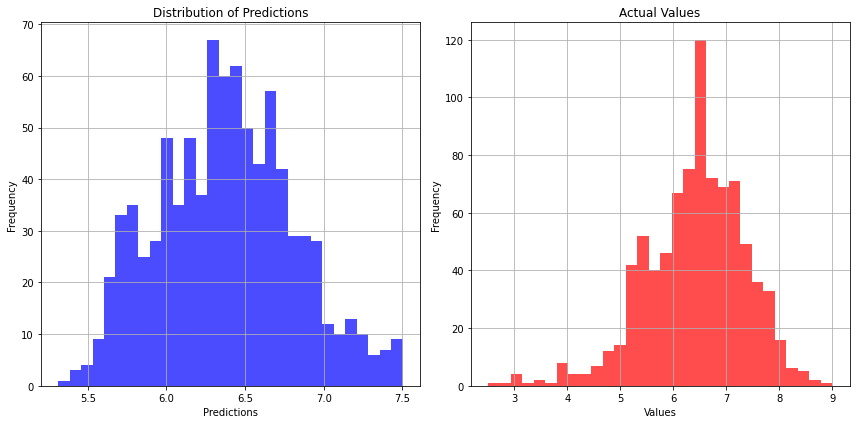

RandomForest model trained and saved.
RMSE: 0.9070182344465268
Std: 0.9404077690058666
Mean Absolut Error: 0.706704621087937


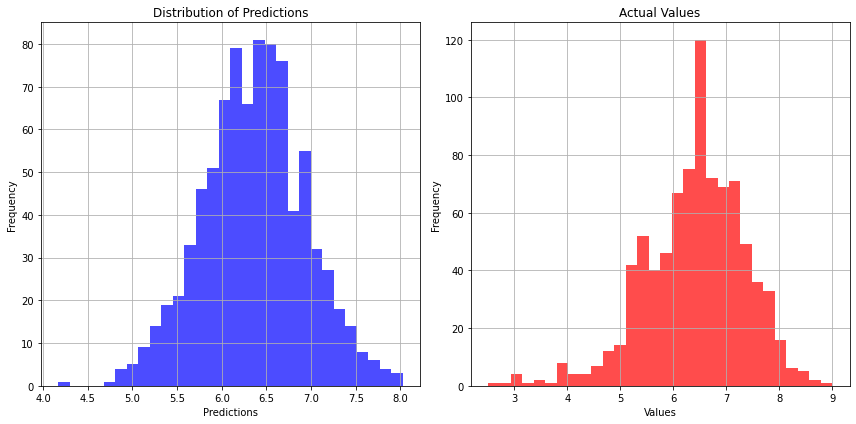

XGB model trained and saved.
RMSE: 0.8481533618543359
Std: 0.9404077690058666
Mean Absolut Error: 0.6583414672227753


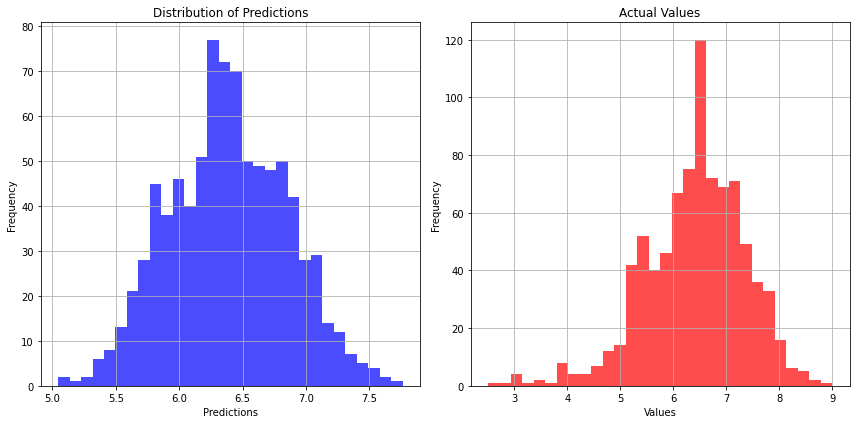

GBM model trained and saved.
RMSE: 0.7062205736143883
Std: 0.8738595660816861
Mean Absolut Error: 0.5412023148487014


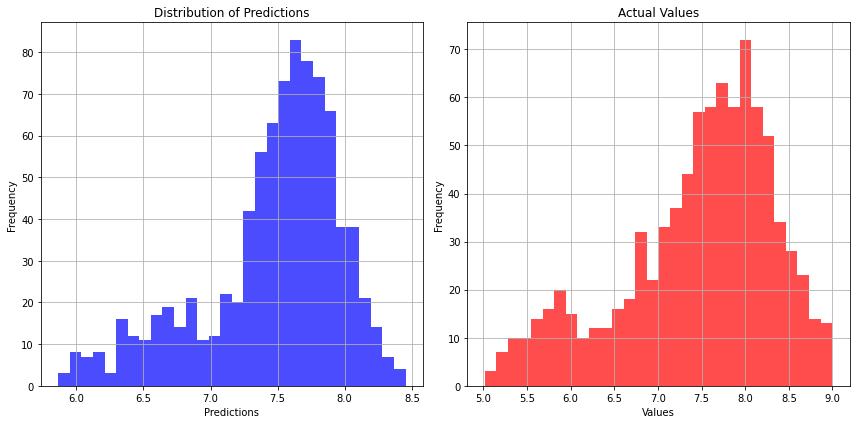

RandomForest model trained and saved.
RMSE: 0.7130558213491842
Std: 0.8738595660816861
Mean Absolut Error: 0.5559793098764501


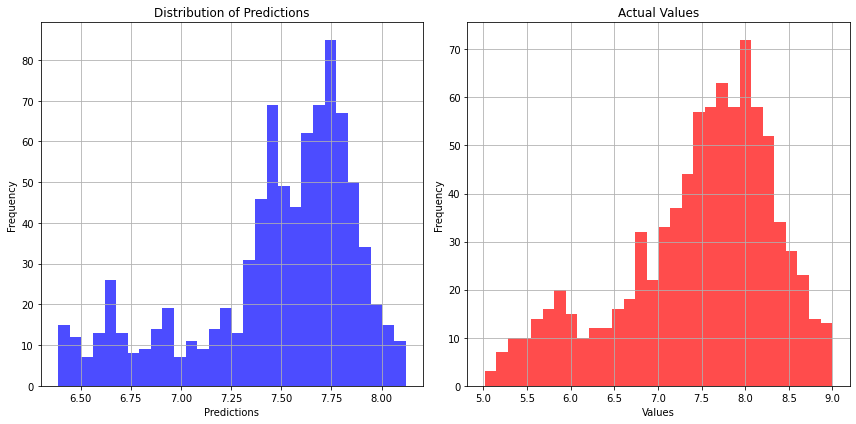

XGB model trained and saved.
RMSE: 0.7012037337023492
Std: 0.8738595660816861
Mean Absolut Error: 0.5347256152833886


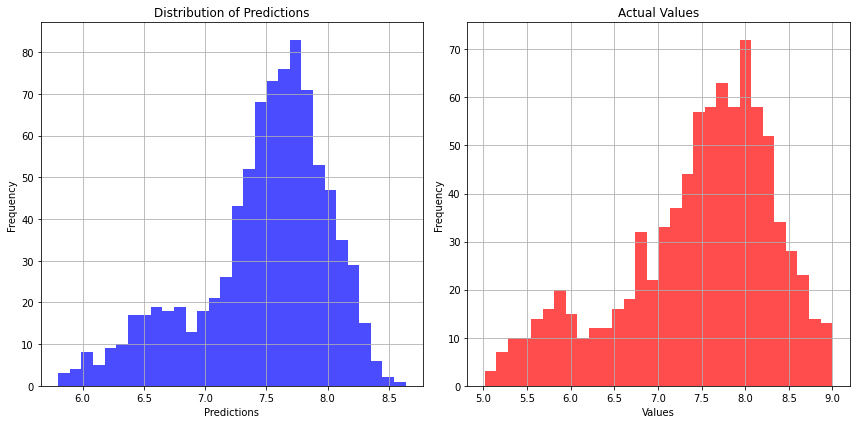

GBM model trained and saved.


In [1052]:
pipeline_critics(inputs_filt, 'RandomForest')
pipeline_critics(inputs_filt, 'XGB')
pipeline_critics(inputs_filt, 'GBM')

pipeline_revenue(inputs_filt, 'RandomForest')
pipeline_revenue(inputs_filt, 'XGB')
pipeline_revenue(inputs_filt, 'GBM')

Hyperparameter tuning

In [1053]:
space_GBM = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

In [1054]:
space_RandomForest = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_features': hp.uniform('max_features', 0.5, 1)
}

In [1055]:
space_XGB = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),
    'reg_alpha': hp.uniform('reg_alpha', 0, 5),
    'reg_lambda': hp.uniform('reg_lambda', 0, 5)
}


In [1056]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import numpy as np

def hyperopt_tuning(algo_type, space, data, goal):
    if goal == 'Revenue':
        feature, target = feat_and_target_revenue(data)
    elif goal == 'Critics':
        feature, target = feat_and_target_critics(data)
    else:
        raise ValueError("Goal not understood")
    xtrain, xtest, ytrain, ytest = data_splitting(feature, target)
    def objective(space):
        if algo_type == 'XGB':
            clf = xgb.XGBRegressor(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                learning_rate=space['learning_rate'],
                subsample=space['subsample'],
                colsample_bytree=space['colsample_bytree'],
                gamma=space['gamma'],
                min_child_weight=space['min_child_weight'],
                reg_alpha=space['reg_alpha'],
                reg_lambda=space['reg_lambda']
            )
        elif algo_type == 'GBM':
            clf = GradientBoostingRegressor(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                learning_rate=space['learning_rate'],
                min_samples_split=int(space['min_samples_split']),
                min_samples_leaf=int(space['min_samples_leaf']),
                subsample=space['subsample'],
                random_state=42
            )
        elif algo_type == 'RandomForest':
            clf = RandomForestRegressor(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                min_samples_split=int(space['min_samples_split']),
                min_samples_leaf=int(space['min_samples_leaf']),
                max_features=space['max_features'],
                random_state=42
            )
        else:
            raise ValueError("Invalid algorithm type. Supported types are 'XGB', 'GBM', 'RandomForest'")
        
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        mse_scores = cross_val_score(clf, xtrain, ytrain, cv=kf, scoring='neg_mean_squared_error')
        mean_mse = np.mean(-mse_scores)
        
        return {'loss': mean_mse, 'status': STATUS_OK}
    
    trials = Trials()

    best_hyperparams = fmin(fn = objective,
                            space = space,
                            algo = tpe.suggest,
                            max_evals = 80,
                            trials = trials)

    for i, result in enumerate(trials.results):
        hyperparameters = trials.trials[i]['misc']['vals']
        score = result['loss']
        print(f"Trial {i+1}: Hyperparameters - {hyperparameters}, Score - {score}")

    
    return best_hyperparams, trials


In [1057]:
#best_hyperparams, _ = hyperopt_tuning('XGB', space_XGB, inputs_filt, 'Critics')
#print("The best hyperparameters are: ", best_hyperparams)

Use models

In [1058]:
def use_models_critics(data, model):
    real_ratings = data['IMDb rating']
    real_ratings = real_ratings.to_list()

    data = data.drop(['IMDb rating', 'Revenue'], axis = 1)

    if model == 'RandomForest':
        loaded_model = joblib.load('RandomForest_critics_model.pkl')
    elif model == 'XGB':
        loaded_model = joblib.load('XGB_critics_model.pkl')
    elif model == 'GBM':
        loaded_model = joblib.load('GBM_critics_model.pkl')
    else:
        raise ValueError("Invalid model type")

    unseen_data_predictions = loaded_model.predict(data)
    abs_element_wise_difference = [abs(x - y) for x, y in zip(real_ratings, unseen_data_predictions)]
    print(abs_element_wise_difference)
    list_mean = sum(abs_element_wise_difference) / len(abs_element_wise_difference)
    print(list_mean)

In [1059]:
def use_models_revenue(data, model):
    real_revenue = data['Revenue']
    real_revenue = real_revenue.to_list()

    data = data.drop(['IMDb rating', 'Revenue'], axis = 1)

    if model == 'RandomForest':
        loaded_model = joblib.load('RandomForest_revenue_model.pkl')
    elif model == 'XGB':
        loaded_model = joblib.load('XGB_revenue_model.pkl')
    elif model == 'GBM':
        loaded_model = joblib.load('GBM_revenue_model.pkl')
    else:
        raise ValueError("Invalid model type")

    unseen_data_predictions = np.power(10, loaded_model.predict(data))
    abs_element_wise_difference = [abs(x - y) for x, y in zip(real_revenue, unseen_data_predictions)]
    print(abs_element_wise_difference)
    list_mean = sum(abs_element_wise_difference) / len(abs_element_wise_difference)
    print(list_mean)

In [1060]:
use_models_critics(play_data_bis, 'RandomForest')

[0.8136400348114634, 0.23243610283193572, 0.515617891802612, 0.9021068610808207, 0.24202791031735593, 0.763094070841972, 1.1562267955751802, 0.6156770089662764, 0.25592714711341014, 0.4999486629971672, 0.36975126006902137, 0.4472508474318717, 0.513164855313569, 0.34046060749274165, 1.853043426462441, 0.11485547239601601, 0.3974263015503192, 0.22460568055344776, 0.9817962834619127, 0.022804856567518073, 0.09336694743140939, 0.02324683533988825, 0.31601155467437536, 0.6507684493238601, 0.4941028581814386, 1.0208003223925193, 0.10473921437346245, 0.0037116661065921264, 1.4012458877169154, 0.44226004059258983, 1.1117830870165992, 0.8017929936074166, 2.3432921427832776, 0.3348870599716385, 0.30652211902453175, 0.5946629509818964, 0.06967447794572035, 0.6968174101229838, 0.8677787462135411, 0.9036138417883626, 0.38658345781892756, 1.4210855037472365, 0.6486156979348827, 0.9199462631863229, 0.6364956186713862, 0.49273942377529245, 0.7543231376219897, 0.34527223657219164, 0.9662976582224427, 0

In [1061]:
use_models_critics(play_data_bis, 'XGB')

[0.4122072219848629, 0.051657676696777344, 0.46833381652831996, 0.8069924354553226, 0.4447336196899414, 0.43712511062622106, 0.6254463195800781, 0.2614559173583988, 0.1451490402221678, 0.013705348968505504, 0.1808943748474121, 0.561333179473877, 0.12923812866210938, 0.2938258171081545, 1.3280898094177243, 0.05395812988281268, 0.41897993087768537, 0.11859512329101562, 0.6502038955688478, 0.17862606048583984, 0.09938468933105504, 0.20048141479492188, 0.5650708198547365, 1.2099832534790043, 0.5603941917419437, 0.8466462135314945, 0.16818714141845703, 0.018031406402587713, 0.9519721984863283, 0.13454875946044886, 0.8368223190307615, 1.0355346679687498, 1.379325199127197, 0.24053134918212926, 0.186332416534424, 0.3693740844726561, 0.6369651794433597, 0.16070146560668963, 0.2111964225769043, 0.8262122154235838, 0.3229366302490231, 1.6852412223815918, 0.6743961334228512, 0.8565125465393066, 0.2674431800842285, 0.42123966217041, 0.9639816284179688, 0.6978772163391112, 1.0976070404052738, 0.518

In [1062]:
use_models_critics(play_data_bis, 'GBM')

[0.7429998089064176, 0.19817829818475818, 0.4222894331772862, 0.7722019505960107, 0.04993273931258102, 0.7343695750605272, 0.9734158681056542, 0.46258232032111035, 0.4945810621141913, 0.30638612173396496, 0.21749541913586423, 0.4455551626760412, 0.18842705663585324, 0.3261590765942213, 1.6422493143311003, 0.1937053880669728, 0.3234210034537037, 0.12494353486330922, 0.904706094570507, 0.06832536864141758, 0.2534307637232258, 0.2074304276539536, 0.04002157007405227, 0.6042331706849433, 0.11253129431374198, 1.1659041645642718, 0.06510609341640627, 0.013020985976496924, 0.9767524061249206, 0.40165736849452127, 1.2564881164400488, 0.6370842167617932, 2.423249722779448, 0.37558209192673253, 0.4537745436924414, 0.34168928830079626, 0.20657969845043844, 0.741413792464563, 0.6557153253819221, 1.1356074267585203, 0.11890528562390656, 1.6695910434003771, 0.5976404586674731, 0.9713037232659563, 0.442040294820365, 0.524195500858343, 0.6274373736628309, 0.47700135678547984, 0.9592295855517463, 0.410

In [1063]:
use_models_revenue(play_data_bis, 'RandomForest')

[46384217.88754685, 18920177.534125198, 18863343.495333806, 2634336.486623095, 33156059.2142749, 637304.231855005, 2319107.362485548, 47548154.83514154, 6421994.701027105, 21816904.421813205, 43775554.10961083, 62308402.041416235, 117756653.41487722, 20208548.081749506, 1749069.067682345, 15105293.479102597, 180547245.0733507, 5907222.007252753, 40901464.559840985, 193607415.1699918, 1439828.9670938514, 28853835.60692951, 7717080.187025239, 45821751.30740255, 10989423.458587416, 16827459.495672837, 15470955.410012454, 8807589.205719233, 15431633.232758697, 48317185.37205206, 74112967.90548739, 83426648.93299706, 1339386.6907164007, 144174497.8745956, 64006599.91750318, 81185.41506743873, 53446.098549762275, 637321797.376215, 106337586.80602998, 27043210.812397707, 8554092.942738863, 26931725.08044547, 11060837.507648349, 4894544.429698385, 78433577.7977685, 608410614.7234752, 29782286.181287684, 9910327.740115035, 73459617.7438064, 2729668.689015456, 2208579.657583691, 63510560.7795487

In [1064]:
use_models_revenue(play_data_bis, 'XGB')

[26376637.67950311, 12860271.805201609, 12315681.264285713, 3601341.345114087, 23399683.208185486, 3771331.2597864717, 2522990.4398369566, 75922114.18181819, 9056805.31892361, 22249777.687407404, 41991741.48062621, 42000668.07058824, 109528904.68711653, 17191477.691619936, 3792125.4580730544, 1664211.9388399422, 179493157.6963471, 4992914.497184608, 31997533.11866042, 188185284.02250335, 5954709.500044014, 6235647.564675754, 6067338.638878266, 49343001.58935484, 190790.00803921372, 15982301.84175378, 12096066.408823527, 2285535.8561150953, 9674345.73283754, 33289201.21095818, 61714898.56338583, 65432660.79317699, 2401896.993155027, 135333201.3937601, 64332529.65932132, 1684939.5932930708, 1768490.3627329194, 626705345.7548473, 102993727.25968844, 40670984.34760125, 23135088.43445693, 30644009.079365082, 12601433.358918006, 7388507.3922913, 83275520.51748171, 595611214.7096773, 19304453.04093866, 2433106.4137931056, 84553113.69463924, 1226343.3791576088, 1881526.2329317331, 10828905.142

In [1065]:
use_models_revenue(play_data_bis, 'GBM')

[73188285.31621903, 8276383.099714432, 1260800.2799073756, 1250323.816929132, 31044067.22432772, 5123203.953673892, 1427884.913924527, 51310062.01739061, 8838717.346990626, 33408297.956521243, 42306045.57716806, 34483705.00494493, 37072470.569294795, 18584157.61231076, 1129553.0965375556, 6910715.729158863, 183813440.37036735, 7641263.044655364, 61526229.6730211, 191113421.63477945, 7876580.450712796, 14715907.989523908, 5153408.9055159595, 16695479.36047344, 6087864.110234521, 6661082.202124491, 9081524.044340432, 8585356.833480246, 2909296.0854602605, 41049626.61079708, 73183550.20926292, 89657731.998829, 1033837.1923323151, 146241637.79327774, 69448755.81742167, 233740.15583563363, 451689.43675380363, 637226319.6556087, 130448776.81509459, 24957534.138924025, 11825556.78797684, 32615617.16153788, 9364336.920425737, 1425840.2869169787, 65700563.91145081, 581507485.1799828, 21421826.511085004, 8453014.514931217, 75896060.89092796, 2068120.27972476, 211208.15412341803, 4524042.48608817

In [1066]:
play_data_bis.columns

Index(['Revenue', 'IMDb rating', 'M-onehot_x', 'M-onehot_y', 'Runtime',
       'Release year_x', 'United States of America-onehot',
       'United Kingdom-onehot', 'India-onehot', 'Canada-onehot',
       'Germany-onehot', 'Japan-onehot', 'South Korea-onehot',
       'Argentina-onehot', 'France-onehot', 'United Kingodm-onehot',
       'Spain-onehot', 'Ireland-onehot', 'Hong Kong-onehot', 'China-onehot',
       'Russia-onehot', 'Australia-onehot', 'Italy-onehot', 'Mexico-onehot',
       'New Zealand-onehot', 'Brazil-onehot', 'Belgium-onehot',
       'Denmark-onehot', 'Sweden-onehot', 'Netherlands-onehot',
       'Philippines-onehot', 'Thriller-onehot', 'Science Fiction-onehot',
       'Horror-onehot', 'Adventure-onehot', 'Action-onehot', 'Drama-onehot',
       'Comedy-onehot', 'Romance Film-onehot', 'Musical-onehot',
       'Fantasy-onehot', 'Family Film-onehot', 'Crime Fiction-onehot',
       'Indie-onehot', 'World cinema-onehot', 'Mystery-onehot',
       'Black-and-white-onehot', 'Crim